# Probability and Statistics for Data Science

Spring 2023: Peter Ralph

https://uodsci.github.io/dsci345

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd

This is here so we can use `\P` and `\E` in LaTeX below.
$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}}$$

# Uncertainty: (how to) deal with it

When we're doing data science, we

- look at data
- make predictions about future values
- infer aspects of the underlying process

Fundamental to all stages are *randomness* and *uncertainty*.

*For instance:* randomized algorithms (e.g., stochastic gradient descent).

*For instance:*

Computing **a statistic**
gives you a number that describes a data set.

**Doing statistics** helps you understand
how reliable that description is
and how well it applies to the wider world.

We understand uncertainty, conceptually and quantitatively,
with **randomness**,

i.e., through *probability*.

## Goals of this class

- Become familiar with different types of probability models.

- Calculate properties of probability models.

- Construct and simulate from realistic models of data generation.

- Be able to test estimation and prediction methods with simulation.

- Gain familiarity with fundamental statistical concepts.

We'll spend a lot of time on *probability models*,
for applications from classical statistics
to machine learning.

Course mechanics: https://uodsci.github.io/dsci345

(break: fill out the survey)

# Getting random

**Today:** *Probability and expectation, conditional probabilities, and random variables.*

First:
let's get some [(pseudo-)randomness](https://numpy.org/doc/stable/reference/random/generator.html).

In [4]:
rng = np.random.default_rng()
help(rng.random)

Help on built-in function random:

random(...) method of numpy.random._generator.Generator instance
    random(size=None, dtype=np.float64, out=None)
    
    Return random floats in the half-open interval [0.0, 1.0).
    
    Results are from the "continuous uniform" distribution over the
    stated interval.  To sample :math:`Unif[a, b), b > a` use `uniform`
    or multiply the output of `random` by ``(b - a)`` and add ``a``::
    
        (b - a) * random() + a
    
    Parameters
    ----------
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    dtype : dtype, optional
        Desired dtype of the result, only `float64` and `float32` are supported.
        Byteorder must be native. The default value is np.float64.
    out : ndarray, optional
        Alternative output array in which to place the result. If siz

[0.99205765 0.33568956 0.17048941 0.19198004 0.18116682 0.53094041
 0.34505477 0.85714241 0.32320189 0.23450211]


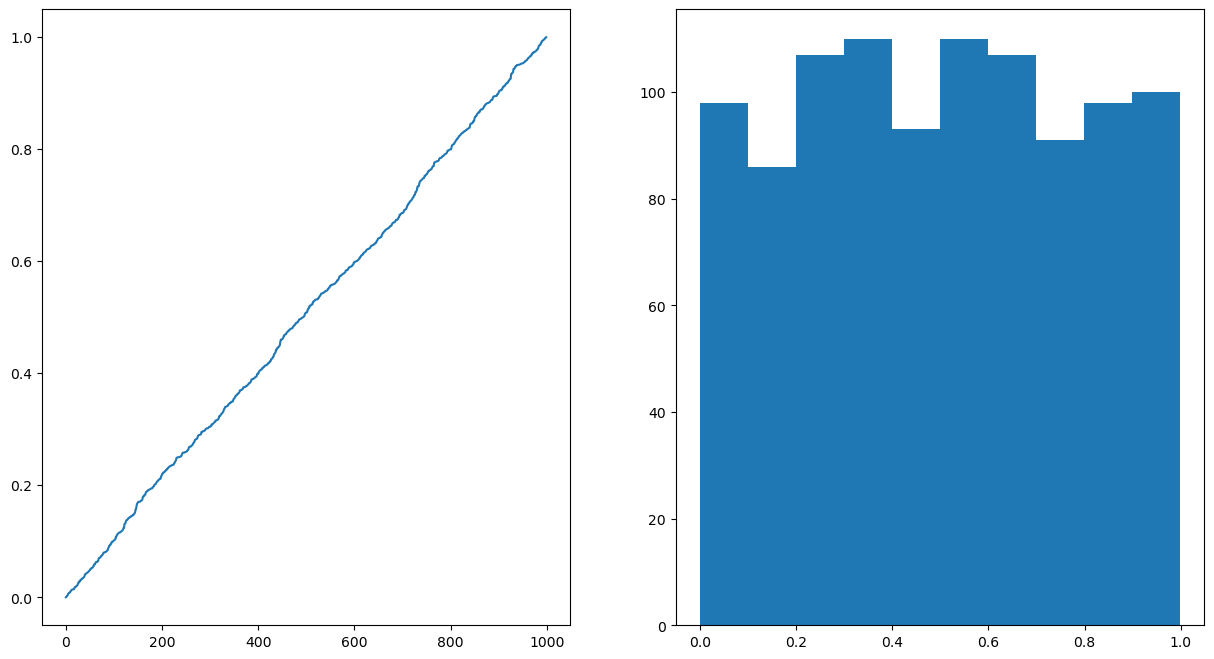

In [5]:
x = rng.random(size=1000)
print(x[:10])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.sort(x))
ax2.hist(x);

**Exercise:** put some other [distributions](https://numpy.org/doc/stable/reference/random/generator.html#distributions) into this code and see what happens.

# Example: false positives

Suppose that I got a positive result on an HIV test. What’s the chance I am HIV positive?
(Here we really mean that “I” am a randomly chosen person from the US population.)

## Background data

The HIV rapid test has 99.4% specificity and 99.8% sensitivity.

Refreshing from [Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity),
specificity is the “true positive” rate and the sensitivity is the “true negative” rate:

- if you have HIV, the chance that it (wrongly) comes out negative is .006 = 0.6%;
- if you don’t have HIV, the chance that it (wrongly) comes out positive is .002 = .2%.

There are currently around
[1.2 million people with HIV in the US](https://www.hiv.gov/hiv-basics/overview/data-and-trends/statistics),
out of a total of [333 million](https://www.census.gov/popclock/),
giving an overall rate of 0.0036 = 0.36%.

In [6]:
true_pos = .994
true_neg = .998
pop_rate = 1.2 / 333

Answer 1: **simulation**

In [7]:
N = int(1e6)
hiv_status = pd.Series( rng.random(N) < pop_rate, name="HIV+")
n = np.sum(hiv_status)
test_result = pd.Series( np.full((N,), ""), name="test")
# hiv+ people
test_result[hiv_status] = ["+" if p < true_pos else "-" for p in rng.random(n)]
# hiv- people
test_result[~hiv_status] = ["-" if p < true_neg else "+" for p in rng.random(N - n)]

pd.crosstab(hiv_status, test_result, margins=True)

test,+,-,All
HIV+,,,
False,1956,994498,996454
True,3528,18,3546
All,5484,994516,1000000


What is the proportion of people who got a positive test result who actually have HIV?

In [15]:
3528/5485

0.6432087511394713

In [14]:
pd.crosstab(hiv_status, test_result, margins=True)

test,+,-,All
HIV+,,,
False,1956,994498,996454
True,3528,18,3546
All,5484,994516,1000000


> Suppose that I got a positive result on an HIV test. What’s the chance I am HIV positive?

In [16]:
hiv_given_plus = sum(hiv_status & (test_result == "+")) / np.sum(test_result == "+")
print(f"The proportion of the {np.sum(test_result == '+')} people "
      f"that had a positive test result that actually have HIV is {100*hiv_given_plus:.2f}%.")

The proportion of the 5484 people that had a positive test result that actually have HIV is 64.33%.


**Does this answer my question?**

*Next answer:* let's use math.

# Probability rules

(i.e., the *axioms of probability*)

## Probability rules

0. *Probabilities are proportions:* $\hspace{2em} 0 \le \P\{A\} \le 1$

1. *Everything:* $\hspace{2em} \P\{ \Omega \} = 1$

2. *Complements:* $\hspace{2em} \P\{ \text{not } A\} = 1 - \P\{A\}$

3. *Disjoint events:* If $\hspace{2em} \P\{A \text{ and } B\} = 0$
    then $\hspace{2em} \P\{A \text{ or } B\} = \P\{A\} + \P\{B\}$.

4. *Independence:* $A$ and $B$ are independent iff $\P\{A \text{ and } B\} = \P\{A\} \P\{B\}$.

5. *Conditional probability:* 
    $$\P\{A \;|\; B\} = \frac{\P\{A \text{ and } B\}}{ \P\{B\} }$$

## Bayes' rule

A consequence is that

$$\P\{B \;|\; A\} = \frac{\P\{B\} \P\{A \;|\; B\}}{ \P\{A\} } .$$

(*Example:* HIV test calculation, on the board.)

In [20]:
pop_rate * true_pos / (pop_rate * true_pos + (1 - pop_rate) * (1 - true_neg))

0.6425339366515835